In [1]:
import joblib

# Örnek: Eğer kaydettiysen bu şekilde yüklenir
X_test = joblib.load("models/X_test.pkl")
y_test = joblib.load("models/y_val.pkl")
y_test = y_test.values if hasattr(y_test, "values") else y_test


## Model Tahminlerinin Yüklenmesi ve Hazırlanması

Eğitim aşamasında kaydedilen her bir modelin (MLP, LightGBM, Random Forest) test seti üzerindeki tahminleri `ensemble_info.pkl` dosyasından yüklenir. MLP modelinin tahminleri, eğitim sırasında normalleştirildiği için `y_scaler` kullanılarak orijinal fiyat ölçeğine geri (`inverse_transform`) dönüştürülür.

Ayrıca, tahminlerin gerçek fiyat aralığının dışına çıkmasını önlemek için `np.clip` fonksiyonu ile değerler, test setindeki minimum ve maksimum değerler arasında sınırlandırılır. Bu, modelin gerçekçi olmayan tahminler üretmesini engeller.

In [2]:
import joblib
import numpy as np

ensemble_dict = joblib.load("models/ensemble_info.pkl")
weights = ensemble_dict["weights"]
mlp_preds = ensemble_dict["mlp_preds"]
y_scaler = joblib.load("models/y_scaler.pkl")

mlp_preds = y_scaler.inverse_transform(mlp_preds.reshape(-1, 1)).flatten()
# gerçek değer aralığına göre kırpılır
mlp_preds= np.clip(mlp_preds, y_test.min(), y_test.max())

lgbm_preds = ensemble_dict["lgbm_preds"]
rf_preds = ensemble_dict["rf_preds"]

#test gerçek değerleri
y_test = joblib.load("models/y_val.pkl")


In [3]:
print("MLP preds min/max:", mlp_preds.min(), mlp_preds.max())
print("LGBM preds min/max:", lgbm_preds.min(), lgbm_preds.max())
print("RF preds min/max:", rf_preds.min(), rf_preds.max())
print("y_test min/max:", y_test.min(), y_test.max())


MLP preds min/max: 10.66 99.95
LGBM preds min/max: 12.166994767665761 99.42620688714403
RF preds min/max: 13.910528402795466 98.10999848913471
y_test min/max: 10.66 99.95


## Ensemble Model ile Nihai Tahminlerin Oluşturulması

Daha önce optimizasyon ile belirlenen ağırlıklar (`weights`) kullanılarak, üç modelin tahminleri ağırlıklı ortalama yöntemiyle birleştirilir. Bu, her modelin güçlü yönlerinden faydalanarak daha dengeli ve robust bir nihai tahmin (`ensemble_preds`) oluşturmayı amaçlar.

Formül: `ensemble_preds = (w1 * mlp_preds) + (w2 * lgbm_preds) + (w3 * rf_preds)`

In [4]:
w1, w2, w3 = weights
ensemble_preds = w1 * mlp_preds + w2 * lgbm_preds + w3 * rf_preds


## Model Performansının Değerlendirilmesi

Oluşturulan nihai tahminler ile gerçek değerler (`y_test`) karşılaştırılarak modelin performansı çeşitli metrikler üzerinden ölçülür.

- **MAE (Mean Absolute Error):** Tahminlerin ortalama mutlak hatası. Fiyat birimi cinsinden yorumlanır.
- **RMSE (Root Mean Squared Error):** Hataların karekökü. Büyük hatalara daha fazla ceza verir.
- **R² (R-squared):** Modelin, hedef değişkendeki varyansın ne kadarını açıkladığını gösterir. 1'e ne kadar yakınsa o kadar iyidir.
- **MAPE (Mean Absolute Percentage Error):** Ortalama mutlak yüzde hatası.
- **SMAPE (Symmetric Mean Absolute Percentage Error):** MAPE'in simetrik versiyonu, sıfır değerlerine karşı daha hassastır.
- **Pearson Korelasyonu:** Tahminler ve gerçek değerler arasındaki doğrusal ilişkiyi ölçer.

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

mae = mean_absolute_error(y_test, ensemble_preds)
rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
r2 = r2_score(y_test, ensemble_preds)
mape = np.mean(np.abs((y_test - ensemble_preds) / y_test)) * 100
smape_val = smape(y_test, ensemble_preds)
corr = np.corrcoef(y_test, ensemble_preds)[0, 1]

print(f"Ensemble Test Sonuçları:\n"
      f"MAE: {mae:.4f}\n"
      f"RMSE: {rmse:.4f}\n"
      f"R²: {r2:.4f}\n"
      f"MAPE: {mape:.2f}%\n"
      f"SMAPE: {smape_val:.2f}%\n"
      f"Pearson Corr: {corr:.4f}")


Ensemble Test Sonuçları:
MAE: 1.8847
RMSE: 2.6989
R²: 0.9610
MAPE: 3.78%
SMAPE: 3.69%
Pearson Corr: 0.9803


In [6]:
print("İlk 10 tahmin:", ensemble_preds[:10].round(2))
print("İlk 10 gerçek:", y_test[:10].round(2))


İlk 10 tahmin: [64.59 64.04 66.73 66.83 68.45 76.17 80.79 75.89 71.46 63.74]
İlk 10 gerçek: 25386    65.06
25387    66.30
25388    66.59
25389    66.94
25390    72.32
25391    79.92
25392    79.24
25393    77.07
25394    69.33
25395    62.12
Name: target_price, dtype: float64


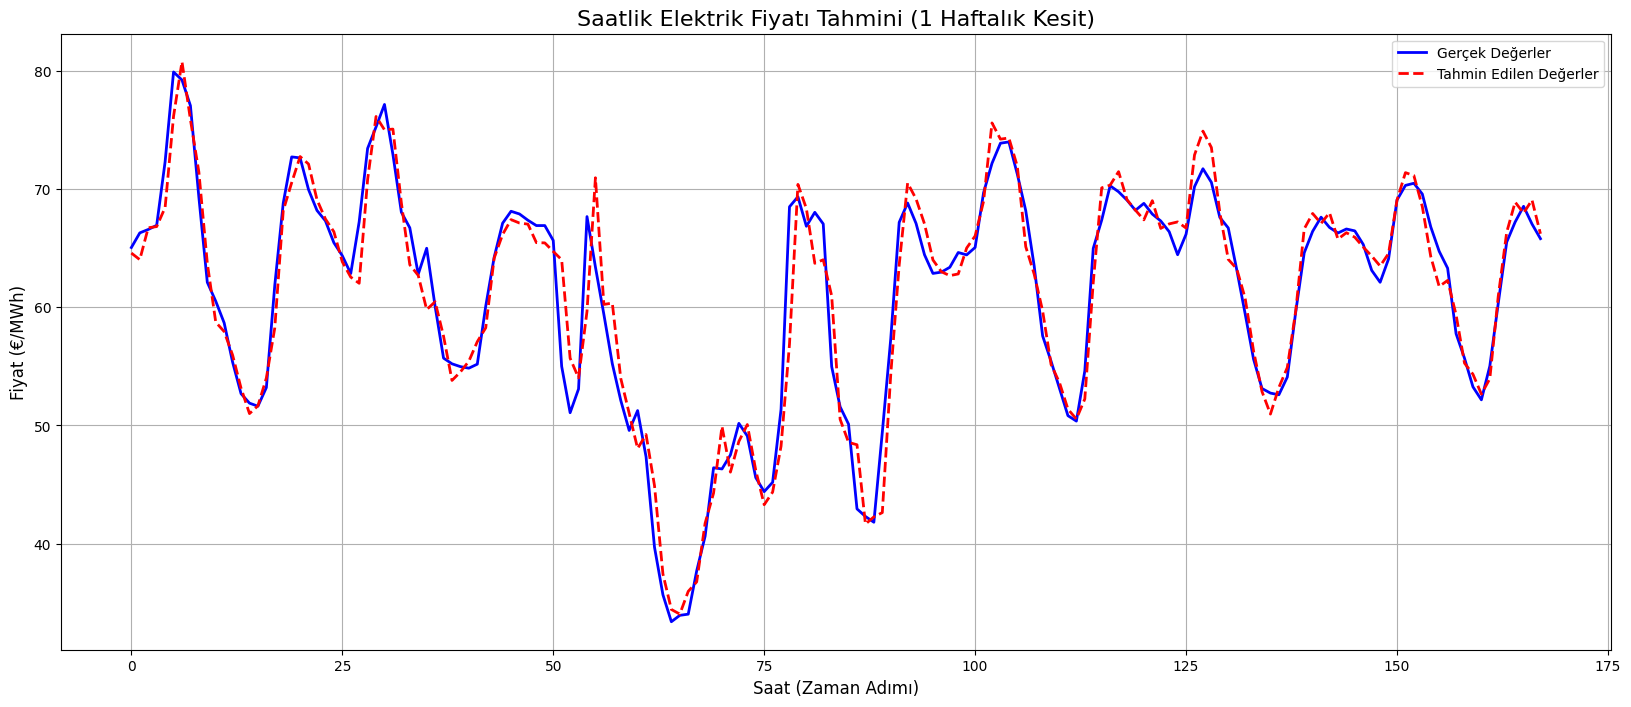

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20, 8))
plt.plot(y_test.values[:168], label='Gerçek Değerler', color='blue', linewidth=2)
plt.plot(ensemble_preds[:168], label='Tahmin Edilen Değerler', color='red', linestyle='--', linewidth=2)
plt.title('Saatlik Elektrik Fiyatı Tahmini (1 Haftalık Kesit)', fontsize=16)
plt.xlabel('Saat (Zaman Adımı)', fontsize=12)
plt.ylabel('Fiyat (€/MWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

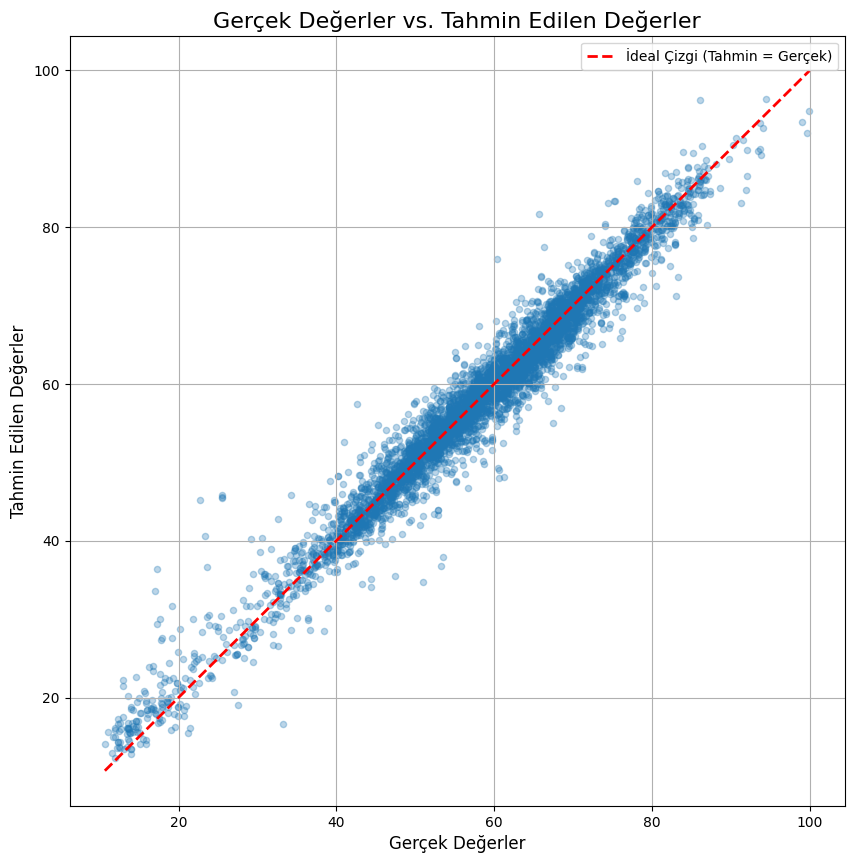

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, ensemble_preds, alpha=0.3, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='İdeal Çizgi (Tahmin = Gerçek)')
plt.title('Gerçek Değerler vs. Tahmin Edilen Değerler', fontsize=16)
plt.xlabel('Gerçek Değerler', fontsize=12)
plt.ylabel('Tahmin Edilen Değerler', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

###  Öznitelik Önem Analizi (Feature Importance)

Modelin başarısını ve tahminlerini hangi faktörlerin yönlendirdiğini anlamak, en az modelin doğruluğu kadar önemlidir. Bu bölümde, LightGBM modelinin "en önemli" bulduğu öznitelikleri analiz edeceğiz.

Yukarıdaki grafik, modelin bir karar verirken hangi öznitelikleri ne sıklıkta kullandığını (`split`) veya bu özniteliklerin modelin kaybını ne kadar azalttığını (`gain`) gösterir. En üstte yer alan öznitelikler, fiyat tahmininde en etkili olanlardır.

<Figure size 1200x1000 with 0 Axes>

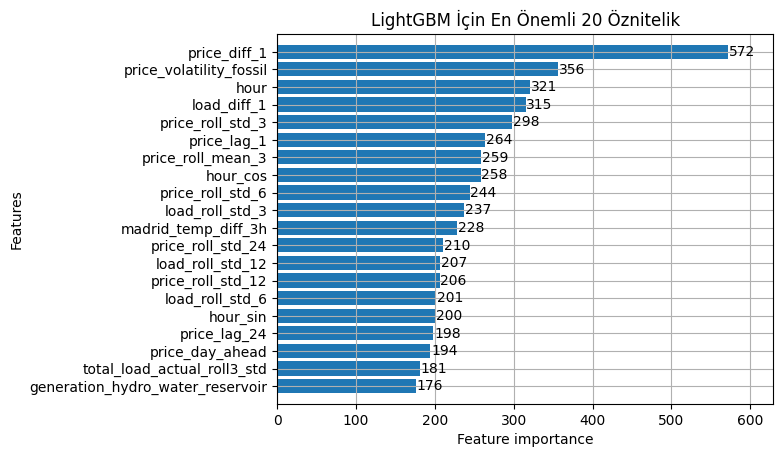

In [17]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd

# Modeli ve test/validasyon verilerini yükle
lgbm_model = joblib.load("models/lgbm_model.pkl") 
X_val = joblib.load("models/X_val.pkl")

# Önem düzeylerini çizdir
plt.figure(figsize=(12, 10))
lgb.plot_importance(lgbm_model, max_num_features=20, height=0.8, 
                    title='LightGBM İçin En Önemli 20 Öznitelik')
plt.show()

SHAP Özet Grafiği (Feature Etkileri)


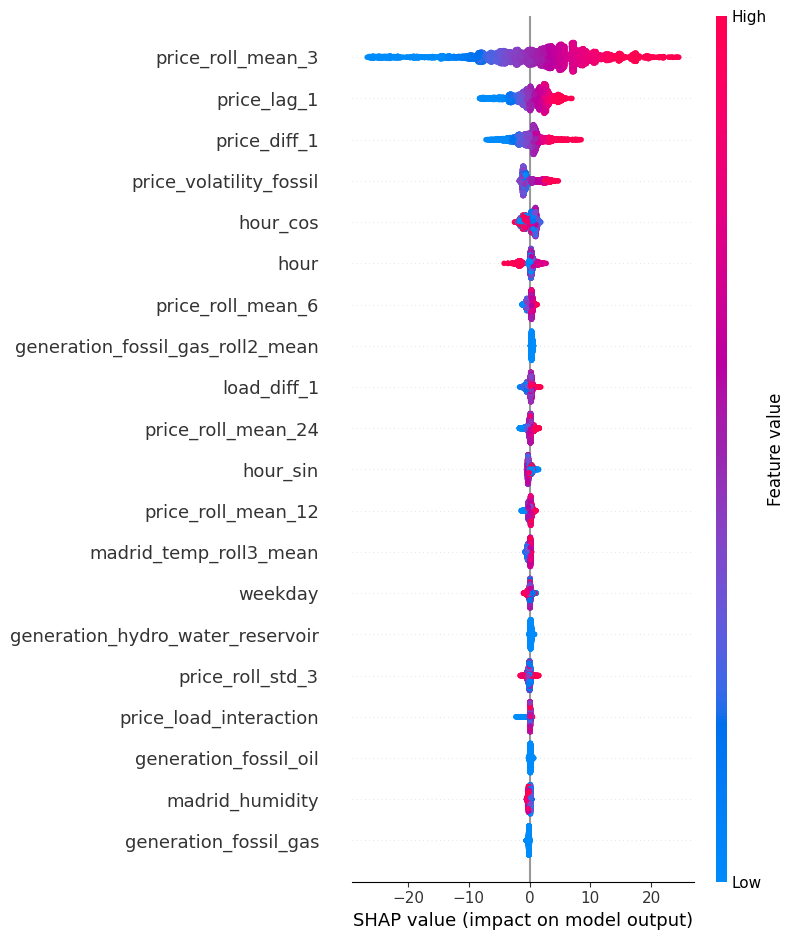

\nSHAP Bar Grafiği (Ortalama Mutlak Etki)


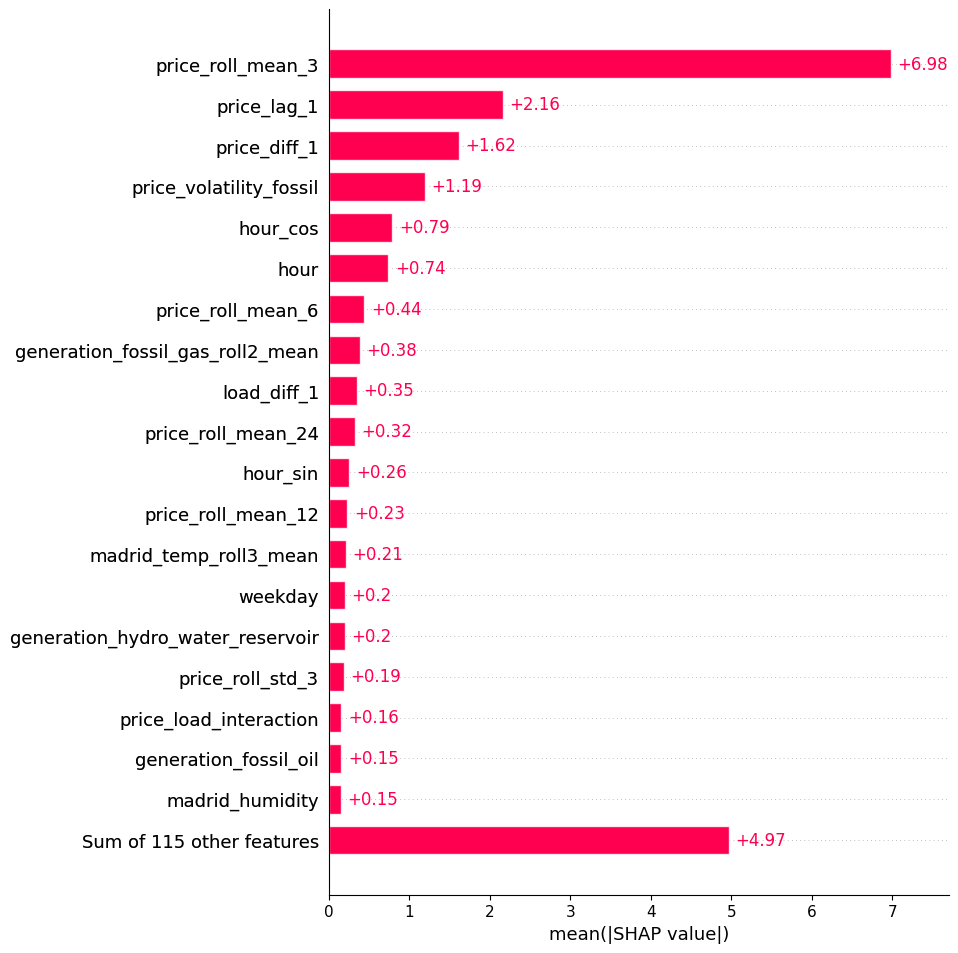

In [ ]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Modeli ve validasyon verisini yükle
model = joblib.load("models/lgbm_model.pkl")
X_val = joblib.load("models/X_val.pkl")

expected_features = model.booster_.feature_name()

X_val_aligned = X_val.reindex(columns=expected_features, fill_value=0)

explainer = shap.Explainer(model)

shap_values = explainer(X_val_aligned)

# Bu grafik, her özniteliğin genel etkisini ve yönünü gösterir.
print("SHAP Özet Grafiği (Feature Etkileri)")
shap.summary_plot(shap_values, X_val_aligned, max_display=20)

# SHAP Bar Grafiği (Ortalama Etki Büyüklüğü)
print("\\nSHAP Bar Grafiği (Ortalama Mutlak Etki)")
shap.plots.bar(shap_values, max_display=20)

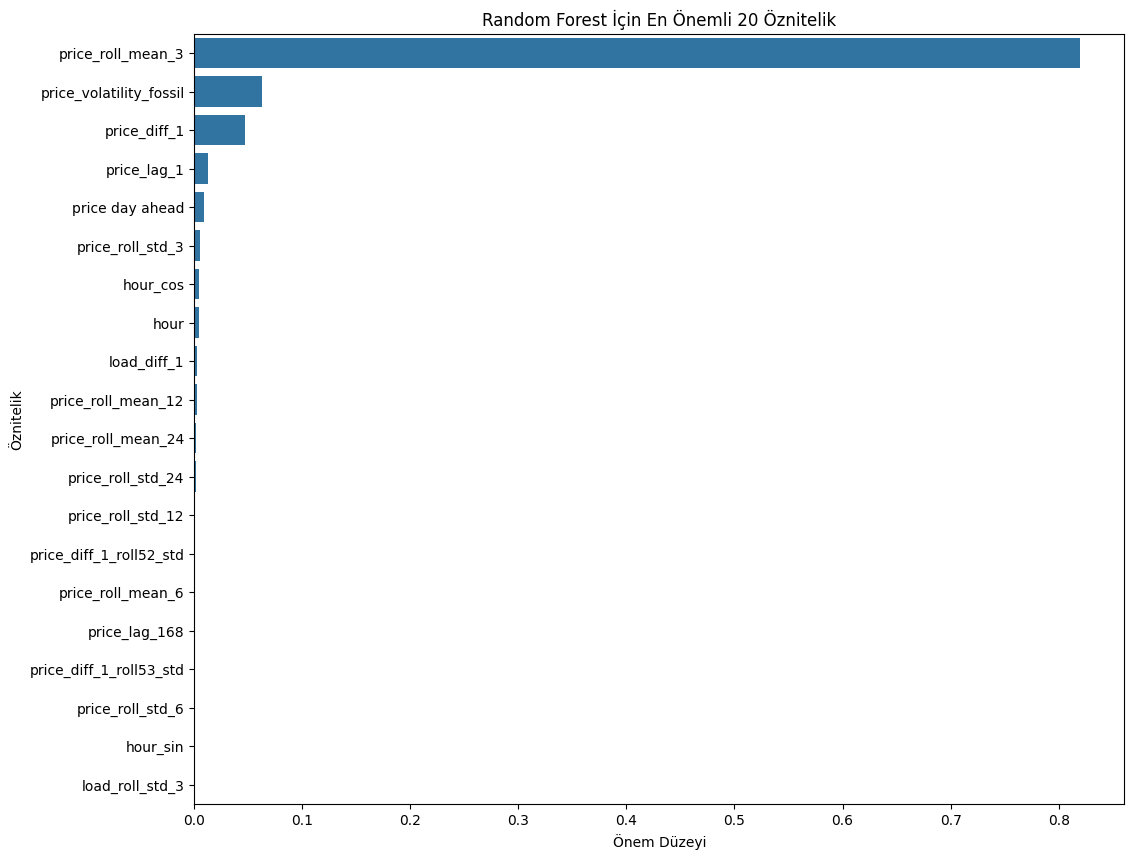

In [23]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest modelini yükle
rf_model = joblib.load("models/rf_model.pkl") 
X_test = joblib.load("models/X_test.pkl") 


feature_importances = pd.DataFrame({
    'feature': rf_model.feature_names_in_,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Grafiği çizdir
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Random Forest İçin En Önemli 20 Öznitelik')
plt.xlabel('Önem Düzeyi')
plt.ylabel('Öznitelik')
plt.show()

### Test Sonuçları Üzerine Değerlendirme

Modeli test seti üzerinde çalıştırdım ve sonuçlar genel olarak oldukça iyi çıktı. Farklı algoritmalardan (MLP, LightGBM, Random Forest) oluşan ensemble model, bu test verisinde hem düşük hata verdi hem de yüksek korelasyon gösterdi.

Aldığım metrikler:

- **MAE:** 1.88
- **RMSE:** 2.70
- **R²:** 0.961
- **MAPE:** %3.78
- **SMAPE:** %3.69
- **Pearson Korelasyonu:** 0.980

Bu sonuçlara göre model gerçek değerlerle oldukça uyumlu tahminler yapmış. RMSE ve MAE değerleri düşük, ayrıca R² ve korelasyon gibi ölçütler 0.96–0.98 civarında. Bu da modelin hem hatasının az olduğunu hem de fiyat hareketlerini iyi takip ettiğini gösteriyor.

MAPE ve SMAPE değerlerinin de %4’ün altında olması, fiyat tahmini gibi zor bir problem için gayet başarılı sayılabilir. Tabii ki bazı uç noktalar veya ani fiyat değişimlerinde model hala zorlanabilir, ama genel olarak sonuçlar tatmin edici.

Kısacası: ensemble yaklaşımı işe yaramış görünüyor ve model sadece eğitime değil, gerçek test verisine de iyi genelleyebiliyor.
